In [1]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 9.5 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / - done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
  Created wheel for torch-geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910454 sha256=c675b76fa9562a22aef9c591377198b781f4f205f5eb1dda648ed35f83d851a2
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch-geometric


In [2]:
import os
from tqdm import tqdm

import numpy as np
import pandas as pd

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torch_geometric import nn as gnn

from matplotlib import pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
splits = ["train", "valid", "test"]

In [4]:
layout_nlp_default = '/kaggle/input/predict-ai-model-runtime/npz_all/npz/layout/nlp/default'
layout_nlp_random = '/kaggle/input/predict-ai-model-runtime/npz_all/npz/layout/nlp/random'
layout_xla_default = '/kaggle/input/predict-ai-model-runtime/npz_all/npz/layout/xla/default'
layout_xla_random = '/kaggle/input/predict-ai-model-runtime/npz_all/npz/layout/xla/random'

tile_xla = '/kaggle/input/predict-ai-model-runtime/npz_all/npz/tile/xla'

In [5]:
def load_data_to_df(directory, split):

    path = os.path.join(directory, split)
    print(path)
    files = [os.path.join(path, file) for file in os.listdir(path)]
    
    data_list = []
    for file in tqdm(files):
        data_list.append(dict(np.load(file)))
        
    return pd.DataFrame(data_list)

In [6]:
df_train = load_data_to_df(tile_xla, "train")
df_valid = load_data_to_df(tile_xla, "valid")

/kaggle/input/predict-ai-model-runtime/npz_all/npz/tile/xla/train


100%|██████████| 5709/5709 [00:41<00:00, 139.02it/s]


/kaggle/input/predict-ai-model-runtime/npz_all/npz/tile/xla/valid


100%|██████████| 676/676 [00:04<00:00, 167.45it/s]


In [7]:
class TileModel(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        op_embedding_dim = 8
        self.opcode_embedding = nn.Embedding(120, op_embedding_dim)
        
        node_feature_dim = 140
        
        conv_out_dim = 48
        self.conv = gnn.GCNConv(op_embedding_dim + node_feature_dim, conv_out_dim)
        
        config_dim = 24
        self.fwd = nn.Sequential(
            nn.Linear(conv_out_dim + config_dim, 48),
            nn.ReLU(),
            nn.Linear(48, 48),
            nn.ReLU(),
            nn.Linear(48, 1)
        )
        
        
    def forward(self, node_feat, node_opcode, edge_index, config_feat):
        """
            Shapes:
                node_feat    - (n, 140)
                node_opcode  - (n, )
                edge_index   - (m, 2)
                config_feat  - (c, 24)
            
            Approach:
                1. Opcode embeddings
                2. Concatenate embeddings to node feature-vector
                3. Convolutional layer for node embeddings
                4. Pooling for graph embedding
                5. Concatenate configuration feature-vector to graph embedding
                6. Forward layer
                7. Flatten
            
            Approach is inline with the paper Phitchaya Mangpo Phothilimthana et. al (2023) 
        """
        node_opcode_embedding = self.opcode_embedding(node_opcode) # (n, 8)
        
        x = torch.concat([node_feat, node_opcode_embedding], dim = 1) # (n, 148)
        
        x = self.conv(x, edge_index) # (n, 48)
                
        x = torch.mean(x, 0) # (48, )    
            
        x = x.repeat(len(config_feat), 1) # (c, 48)
        
        x = torch.concat([x, config_feat], dim = 1) # (c, 72)
        
        x = self.fwd(x) # (c, 1)
        
        return torch.flatten(x) # (c, )
        

In [8]:
class TileDataset(Dataset):
    
    def __init__(self, tiles):
        self.tiles = tiles
    
    def __len__(self):
        return len(self.tiles)
    
    def __getitem__(self, idx):
        
        node_feat = torch.from_numpy(self.tiles.iloc[idx]['node_feat'])
        node_opcode = torch.from_numpy(self.tiles.iloc[idx]['node_opcode']).type(torch.int64)
        edge_index = torch.from_numpy(self.tiles.iloc[idx]['edge_index']).permute(1, 0)
        config_feat = torch.from_numpy(self.tiles.iloc[idx]['config_feat'])
        config_runtime = torch.from_numpy(self.tiles.iloc[idx]['config_runtime'])
        config_runtime_normalizers = torch.from_numpy(self.tiles.iloc[idx]['config_runtime_normalizers'])
        
        return {
            "node_feat": node_feat,
            "node_opcode": node_opcode,
            "edge_index": edge_index,
            "config_feat": config_feat,
            "y": config_runtime / config_runtime_normalizers
        }
    
    def __iter__(self):
        self.i = 0
        return self
    
    def __next__(self):
        if self.i < len(self.tiles):
            item = self[self.i]
            self.i += 1
            return item
        else:
            raise StopIteration
    
train_dataset = TileDataset(df_train)
valid_dataset = TileDataset(df_valid)

In [9]:
for key in train_dataset[0].keys():
    print(f"{key} has type {train_dataset[0][key].dtype} and {len(train_dataset[0][key])} items")
    
train_dataset[0]

node_feat has type torch.float32 and 31 items
node_opcode has type torch.int64 and 31 items
edge_index has type torch.int64 and 2 items
config_feat has type torch.float32 and 1537 items
y has type torch.float32 and 1537 items


{'node_feat': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 1., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.]]),
 'node_opcode': tensor([ 63,  63,   2,  63,  63,   2,  63,  11,  63,  11,  63,  24,  13,  59,
          63,  41,  63,  41,  26,  25,   2,  59,  24,  70,  59,  70, 100,  63,
          63,  63,  41]),
 'edge_index': tensor([[ 2,  2,  5,  5,  7,  9, 12, 13, 13, 15, 15, 17, 17, 18, 18, 19, 20, 20,
          21, 23, 23, 23, 24, 25, 25, 25, 26, 26, 26, 30, 30, 30, 30],
         [ 0,  1,  3,  4,  6,  8, 11, 10, 12,  7, 14,  9, 16, 15, 17, 18, 13, 19,
          20,  2, 21, 22, 10,  5, 22, 24, 18, 23, 25, 26, 27, 28, 29]]),
 'config_feat': tensor([[16., 16.,  1.,  ...,  0.,  0.,  0.],
         [ 3.,  2.,  1.,  ...,  0.,  0.,  0.],
         [ 1., 14.,  1.,  ...,  0.,  0.,  0.],
         ...,
         [20., 20.,  1.,  ...,  0.

In [10]:
model = TileModel()

data = train_dataset[0]

model(data['node_feat'], data['node_opcode'], data['edge_index'], data['config_feat'])

tensor([20378.0469, 20381.6914, 20381.5215,  ..., 20375.9316, 20377.6543,
        20377.6953], grad_fn=<ReshapeAliasBackward0>)

In [11]:
# Count the number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters in the model: {total_params}")

Total parameters in the model: 14017


## Training

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = TileModel().to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

model.train()

epochs = 10
losses = []

for i in range(epochs):
    for tile in tqdm(train_dataset, desc="Epoch " + str(i)):
    
        node_feat = tile["node_feat"].to(device)
        node_opcode = tile["node_opcode"].to(device)
        edge_index = tile["edge_index"].to(device)
        config_feat = tile["config_feat"].to(device)
    
    
        pred = model(node_feat, node_opcode, edge_index, config_feat).to("cpu")
        loss = loss_fn(pred, tile["y"])
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    
    
    current_losses = 0

    for tile in tqdm(valid_dataset, desc="Loss Epoch " + str(i)):
        node_feat = tile["node_feat"].to(device)
        node_opcode = tile["node_opcode"].to(device)
        edge_index = tile["edge_index"].to(device)
        config_feat = tile["config_feat"].to(device)
    
    
        pred = model(node_feat, node_opcode, edge_index, config_feat).to("cpu")
        loss = loss_fn(pred, tile["y"])
        current_losses += loss.item()
    
    losses.append(current_losses / len(train_dataset))    
    

Loss Epoch 9: 100%|██████████| 676/676 [00:01<00:00, 565.51it/s]


[3.5653800841993157,
 3.5653710548212447,
 3.566595951047915,
 3.56534250447829,
 3.5651856196659586,
 3.5651862596667865,
 3.5652051315685145,
 3.567117955183937,
 3.5677393888253675,
 3.567739338606706]

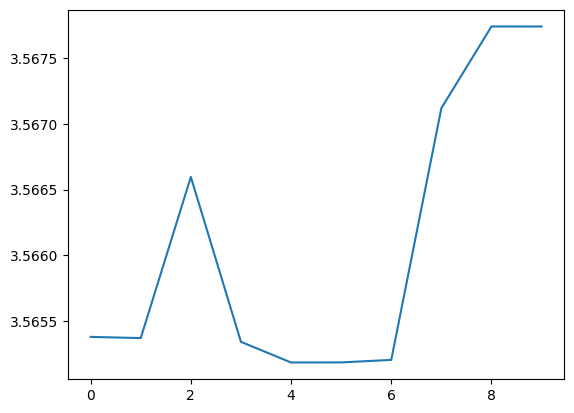

In [13]:
# Plot losses
plt.plot(losses)
losses

In [14]:
def validate_model(model):
    
    
    # Make predictions
    predictions = []

    model.eval()

    for tile in tqdm(valid_dataset):
        node_feat = tile["node_feat"].to(device)
        node_opcode = tile["node_opcode"].to(device)
        edge_index = tile["edge_index"].to(device)
        config_feat = tile["config_feat"].to(device)
    
        out = model(node_feat, node_opcode, edge_index, config_feat).to("cpu")
        predictions.append(torch.sort(out).indices)

    # Calculate score
    score = 0.0

    for i, tile in tqdm(enumerate(valid_dataset), total=len(valid_dataset)):
        best_prediction = min([valid_dataset[i]["y"][pred_ind] for pred_ind in predictions[i][:5]])
        best_total = min(valid_dataset[i]["y"])
        score += 2.0 - best_prediction / best_total

    avg_score = score / len(valid_dataset)
    print("Score:", avg_score)
    return avg_score
    

In [15]:
validate_model(model)

100%|██████████| 676/676 [00:07<00:00, 94.71it/s] 

Score: tensor(0.4396)


tensor(0.4396)